In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time

from joblib import Parallel, delayed
from utilities2015 import *

%matplotlib inline

from clustering import *

In [2]:
surround_high_contrast_thresh = .1
coherence_limit = .25
# significance_limit = .8
area_limit = 60000
nonoverlapping_area_limit = 2.
bg_texton = 3
bg_texton_percentage = .2
# significance_limit = -0.81
significance_limit = 0
consensus_limit = -20

In [3]:
dm = DataManager(stack='MD593', section=138, segm_params_id='tSLIC200')
# dm._load_image(format='gray')

In [4]:
dm.load_multiple_results(results=['texHist', 'segmentation', 'texMap', 'neighbors', 
                                  'edgeCoords', 'spCentroids', 'edgeNeighbors', 'dedgeNeighbors',
                                  'spCoords', 'edgeMidpoints', 'spAreas'])

In [5]:
all_seed_cluster_score_dedge_tuples = dm.load_pipeline_result('allSeedClusterScoreDedgeTuples')

In [6]:
all_seed, all_clusters, all_cluster_scores, all_cluster_dedges = zip(*all_seed_cluster_score_dedge_tuples)

In [7]:
def compute_cluster_coherence_score(cluster, verbose=False):
    
    if len(cluster) > 1:
        cluster_avg = dm.texton_hists[cluster].mean(axis=0)
        ds = np.squeeze(chi2s([cluster_avg], dm.texton_hists[list(cluster)]))
        var = ds.mean()
    else:
        var = 0
    
    return var

def compute_cluster_significance_score(*args, **kwargs):
    return dm.compute_cluster_score(*args, **kwargs)[0]

In [8]:
growed_from = defaultdict(list)
for se, cl in zip(all_seed, all_clusters):
    growed_from[se].append(cl)
    
# all_cluster_consensus = []
# for se, cl in zip(all_seed, all_clusters):
#     total_diff = 0
#     c = 0
#     for s in cl:
#         if s != se:
#             if len(d[s]) > 0:
#                 diff_size = np.min([len((set(cl2)|set(cl))-(set(cl2)&set(cl))) for cl2 in d[s]])
#                 total_diff += diff_size
#                 c += 1
#     if c > 0:
#         mean_diff = total_diff/float(c)
#         all_cluster_consensus.append(-mean_diff)
#     else:
#         all_cluster_consensus.append(-np.inf)

# all_cluster_consensus = np.array(all_cluster_consensus)

In [9]:
all_cluster_consensus = []
for se, cl in zip(all_seed, all_clusters):
    diff_sizes = [np.min([len((set(cl2)|set(cl))-(set(cl2)&set(cl))) for cl2 in growed_from[s]]) 
                  for s in cl if s != se and len(growed_from[s]) > 0]
    if len(diff_sizes) > 0:
        mean_diff = np.mean(diff_sizes)
        all_cluster_consensus.append(-mean_diff)
    else:
        all_cluster_consensus.append(-np.inf)
all_cluster_consensus = np.array(all_cluster_consensus)

In [10]:
len(all_clusters)

5846

In [11]:
# all_cluster_sigs = np.array([compute_cluster_significance_score(cl, method='rc-mean') for cl in all_clusters])

all_cluster_sigs = np.array(all_cluster_scores)
all_cluster_coherences = np.array([compute_cluster_coherence_score(cl) for cl in all_clusters])

In [12]:
all_cluster_sigs_perc = np.array(Parallel(n_jobs=16)(delayed(compute_cluster_significance_score)(cl, method='percentage-soft',
                                thresh=surround_high_contrast_thresh) for cl in all_clusters))

# all_cluster_sigs_perc = np.array([compute_cluster_significance_score(cl, method='percentage-soft',
#                                                                thresh=surround_high_contrast_thresh) 
#                              for cl in all_clusters])

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warn

In [13]:
all_cluster_hists = [dm.texton_hists[cl].mean(axis=0) for cl in all_clusters]
all_cluster_entropy = np.nan_to_num([-np.sum(hist[hist!=0]*np.log(hist[hist!=0])) for hist in all_cluster_hists])

all_cluster_centroids = np.array([dm.sp_centroids[cl, ::-1].mean(axis=0) for cl in all_clusters])

all_cluster_compactness = np.array([len(eds)**2/float(len(cl)) for cl, eds in zip(all_clusters, all_cluster_dedges)])
all_cluster_compactness = .001 * np.maximum(all_cluster_compactness-40,0)**2

all_cluster_area = np.array([dm.sp_areas[cl].sum() for cl in all_clusters])

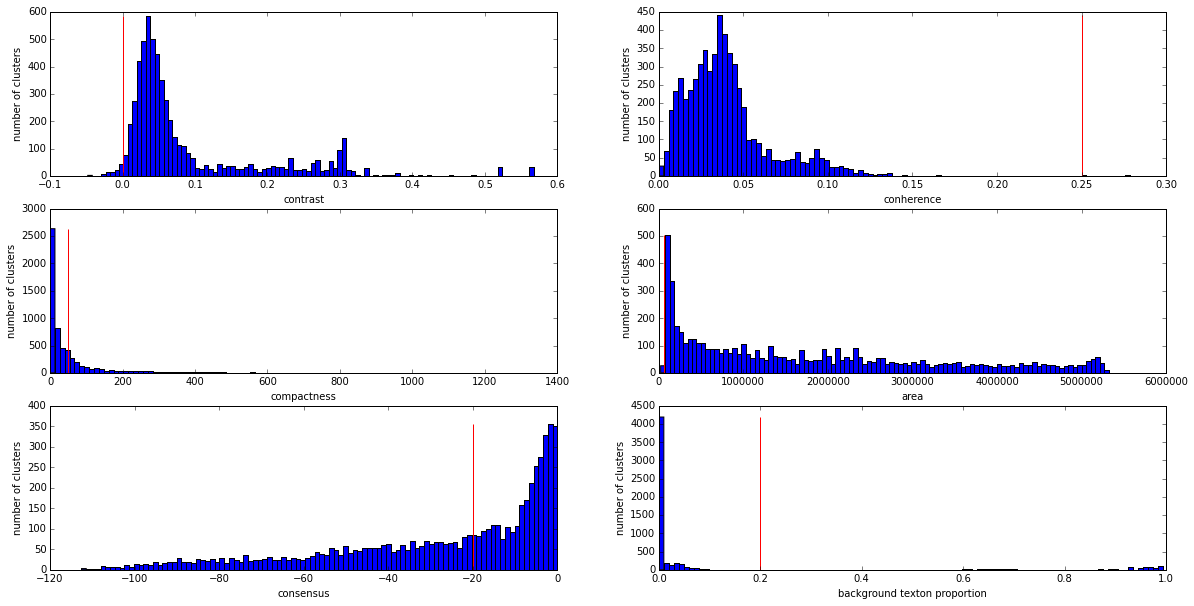

In [14]:
fig, axes = plt.subplots(3, 2, squeeze=True, figsize=(20,10))
axes = axes.flatten()
h = axes[0].hist(all_cluster_sigs, bins=100);
axes[0].set_xlabel('contrast');
axes[0].set_ylabel('number of clusters');
axes[0].vlines(significance_limit, 0, h[0].max(), color='r');
h = axes[1].hist(all_cluster_coherences, bins=100);
axes[1].set_xlabel('conherence');
axes[1].set_ylabel('number of clusters');
axes[1].vlines(coherence_limit, 0, h[0].max(), color='r');
h = axes[2].hist(all_cluster_compactness, bins=100);
axes[2].set_xlabel('compactness');
axes[2].set_ylabel('number of clusters');
axes[2].vlines(50, 0, h[0].max(), color='r');
h = axes[3].hist(all_cluster_area, bins=100);
axes[3].set_xlabel('area');
axes[3].set_ylabel('number of clusters');
axes[3].vlines(area_limit, 0, h[0].max(), color='r');
h = axes[4].hist(all_cluster_consensus[all_cluster_consensus!=-np.inf], bins=100);
axes[4].set_xlabel('consensus');
axes[4].set_ylabel('number of clusters');
axes[4].vlines(consensus_limit, 0, h[0].max(), color='r');
h = axes[5].hist([hist[bg_texton] for hist in all_cluster_hists], bins=100);
axes[5].set_xlabel('background texton proportion');
axes[5].set_ylabel('number of clusters');
axes[5].vlines(bg_texton_percentage, 0, h[0].max(), color='r');

In [15]:
remaining_cluster_indices = [i for i, (cl, coh, sig, perc, ent, cent, comp, area, cons, hist) in enumerate(zip(all_clusters, 
                                                                                      all_cluster_coherences, 
                                                                                      all_cluster_sigs,
                                                                                    all_cluster_sigs_perc,
                                                                                      all_cluster_entropy,
                                                                                      all_cluster_centroids,
                                                                                      all_cluster_compactness,
                                                                                      all_cluster_area,
                                                                                    all_cluster_consensus,
                                                                                    all_cluster_hists)) 
            if coh < coherence_limit and sig > significance_limit and area > area_limit \
                             and cons > consensus_limit and \
#                  comp < 50 and \
             ((ent > 1.5 and hist[bg_texton] < bg_texton_percentage) or \
              (cent[0] - dm.xmin > 800 and \
               dm.xmax - cent[0] > 800 and \
               cent[1] - dm.ymin > 800 and \
               dm.ymax - cent[1] > 800)
             )]

In [16]:
sys.stderr.write('remaining_cluster_indices = %d\n'%len(remaining_cluster_indices))

remaining_cluster_indices = 2292


In [17]:
all_remaining_seed = [all_seed[i] for i in remaining_cluster_indices]
all_remaining_clusters = [all_clusters[i] for i in remaining_cluster_indices]
all_remaining_cluster_sigs = [all_cluster_sigs[i] for i in remaining_cluster_indices]
all_remaining_cluster_sigpercs = [all_cluster_sigs_perc[i] for i in remaining_cluster_indices]
all_remaining_cluster_coherences = [all_cluster_coherences[i] for i in remaining_cluster_indices]
all_remaining_cluster_dedges = [all_cluster_dedges[i] for i in remaining_cluster_indices]
all_remaining_cluster_consensus = [all_cluster_consensus[i] for i in remaining_cluster_indices]
all_remaining_seed_cluster_score_dedge_tuples = [all_seed_cluster_score_dedge_tuples[i] for i in remaining_cluster_indices]

In [99]:
nonoverlapping_area_limit = 3

In [100]:
t = time.time()

all_remaining_seed_cluster_sig_coh_dedge_tuples = zip(all_remaining_seed, all_remaining_clusters, 
                                            all_remaining_cluster_sigs, 
                                          all_remaining_cluster_sigpercs,
                                          all_remaining_cluster_coherences,
                                         all_remaining_cluster_dedges,
                                                     all_remaining_cluster_consensus)

# tuple_indices_grouped, tuples_grouped, _ = group_tuples(all_seed_cluster_sig_coh_dedge_tuples, 
#                                                          val_ind = 1,
#                                                          metric='jaccard',
#                                                          dist_thresh=.2)

# merge if area difference is less than 1% of entire frame
tuple_indices_grouped, tuples_grouped, _ = group_tuples(all_remaining_seed_cluster_sig_coh_dedge_tuples, 
                                                         val_ind = 1,
                                                         metric='nonoverlap-area',
                                                         dist_thresh=nonoverlapping_area_limit, 
                                                        sp_areas=dm.sp_areas) 

print time.time() - t

14.1722230911


In [101]:
n_group = len(tuple_indices_grouped)
sys.stderr.write('%d groups\n'%n_group)

236 groups


In [102]:
all_seeds_grouped, all_clusters_grouped, \
all_sigs_grouped, all_sigpercs_grouped, all_cohs_grouped, all_dedges_grouped,\
all_consensus_grouped = [list(map(list, lst)) for lst in zip(*[zip(*g) for g in tuples_grouped])]

In [103]:
# all_scores_grouped = [[compute_cluster_significance_score(g, method='percentage') for g in cg] 
#                           for cg in all_clusters_grouped]

all_cluster_grouped_union = [set.union(*map(set, cls)) for cls in all_clusters_grouped]
# all_cluster_grouped_union = [smart_union(cls) for cls in all_clusters_grouped]
# all_scores_grouped = np.array([len(seeds) / float(len(union_cl)) for seeds, union_cl in zip(all_seeds_grouped,
#                                                                                   all_cluster_grouped_union)])
all_scores_grouped = np.array([-dm.sp_areas[list(set(union_cl)-set(seeds))].sum()
                               for seeds, union_cl in zip(all_seeds_grouped, all_cluster_grouped_union)])

In [104]:
group_rep_indices = map(np.argmax, all_sigs_grouped)

# rep_tuples = [(sc, sig_grp[rep_ind], cl_grp[rep_ind], dedge_grp[rep_ind], gi) 
#                 for gi, (rep_ind, cl_grp, dedge_grp, sig_grp, sc) in enumerate(zip(group_rep_indices, 
#                                                                               all_clusters_grouped, 
#                                                                               all_dedges_grouped,
#                                                                             all_sigs_grouped, 
#                                                                              all_scores_grouped))]

group_rep_clusters = [cls[rep] for cls, rep in zip(all_clusters_grouped, group_rep_indices)]
# group_rep_clusters = [smart_union(cls) for cls in all_clusters_grouped]
# group_rep_clusters = [cls[0] for cls in all_clusters_grouped]
# group_contrasts = [compute_cluster_significance_score(cl, method='percentage-soft',
#                                     thresh=surround_high_contrast_thresh) for cl in group_rep_clusters]

group_contrasts = [compute_cluster_significance_score(cl, method='rc-mean') for cl in group_rep_clusters]

# for cl in rep_clusters:
#     uni = {}
#     for s in cl:
#         cands = [all_clusters[i] for i in np.where(all_seed == s)[0]]
#         c = cands[np.argsort(map(len, cands))]
#         uni.add(c)            
#     extra = uni - set(cl)
#     extra_area = np.sum(dm.sp_areas[list(extra)])
#     rep_inbreed

# group_contrasts = [rep_tuples]
group_inbreed = all_scores_grouped
group_consensus = np.array([vs[rep] for vs, rep in zip(all_consensus_grouped, group_rep_indices)])
group_sigperc = np.array([vs[rep] for vs, rep in zip(all_sigpercs_grouped, group_rep_indices)])
group_size = [len(g) for g in all_clusters_grouped]
# rep_tuples_ranked = sorted(rep_tuples, key=itemgetter(1), reverse=True)

def scores_to_vote(scores):
    vals = np.unique(scores)
    d = dict(zip(vals, np.linspace(0, 1, len(vals))))
    votes = np.array([d[s] for s in scores])
    votes = votes/votes.sum()
    return votes

d1 = scores_to_vote(group_contrasts)
d2 = scores_to_vote(group_inbreed)
d3 = scores_to_vote(group_size)
d4 = scores_to_vote(group_consensus)
group_indices_ranked = np.argsort(.5*d1 + 0*d4 + 0*d3)[::-1]

# rep_tuples_ranked = [rep_tuples[i] for i in group_indices_ranked]

rep_inbreed_ranked = [group_inbreed[i] for i in group_indices_ranked]
rep_contrast_ranked = [group_contrasts[i] for i in group_indices_ranked]
rep_sigperc_ranked = [group_sigperc[i] for i in group_indices_ranked]
# rep_clusters_ranked = [smart_union(all_clusters_grouped[i]) for i in group_indices_ranked]
# rep_clusters_ranked = [all_clusters_grouped[i][np.argmax(all_sigs_grouped[i])] for i in group_indices_ranked]
rep_clusters_ranked = [all_clusters_grouped[i][np.argmax(all_sigpercs_grouped[i])] for i in group_indices_ranked]
# rep_clusters_ranked = [all_clusters_grouped[i][np.argmax(map(len, all_clusters_grouped[i]))] for i in group_indices_ranked]
rep_dedges_ranked = [dm.find_boundary_dedges_ordered(cl) for cl in rep_clusters_ranked]

# rep_score_ranked = map(itemgetter(0), rep_tuples_ranked)
# rep_sig_ranked = map(itemgetter(1), rep_tuples_ranked)
# rep_clusters_ranked = map(itemgetter(2), rep_tuples_ranked)
# rep_dedges_ranked = map(itemgetter(3), rep_tuples_ranked)

# group_indices_ranked = map(itemgetter(4), rep_tuples_ranked)

# rep_entropy_ranked = np.nan_to_num([-np.sum(texton_hists[cl].mean(axis=0)*np.log(texton_hists[cl].mean(axis=0)) )
#                       for cl in rep_clusters_ranked])

# sp_centroids = dm.load_pipeline_result('spCentroids')[:, ::-1]
# rep_centroids_ranked = np.array([sp_centroids[cl].mean(axis=0) for cl in rep_clusters_ranked])

# rep_compactness_ranked = np.array([len(eds)**2/float(len(cl)) for cl, eds in zip(rep_clusters_ranked, rep_dedges_ranked)])
# rep_compactness_ranked = .001 * np.maximum(rep_compactness_ranked-40,0)**2

good_clusters = rep_clusters_ranked
good_dedges = rep_dedges_ranked

dedges missing 14 36%
dedges missing 52 73%
dedges missing 8 30%


In [ ]:
a, b, _ = group_tuples(rep_clusters_ranked, metric='jaccard', dist_thresh=.5) 

In [ ]:
a

In [ ]:
dm.visualize_clusters_in_subplots([rep_clusters_ranked[i] for i in a[6]])

In [ ]:
merged_clusters = [rep_clusters_ranked[g[np.argmax([rep_contrast_ranked[i] for i in g])]] for g in a]
merged_clusters_sigpercs = [rep_sigperc_ranked[g[np.argmax([rep_contrast_ranked[i] for i in g])]] for g in a]
merged_clusters_ranked = [merged_clusters[i] for i in np.argsort(merged_clusters_sigpercs)[::-1]]

# merged_clusters = [rep_clusters_ranked[np.argmax([rep_sigperc_ranked[i] for i in g])] for g in a]
merged_dedges_ranked = [dm.find_boundary_dedges_ordered(cl) for cl in merged_clusters_ranked]

In [ ]:
for i, cl in enumerate(rep_clusters_ranked):
    print i
    _ = dm.find_boundary_dedges_ordered(cl)

In [ ]:
# which clusters contain the interested sps

research_sp = 788

gs_all = [gi for gi, cl in enumerate(all_clusters) if research_sp in cl]
print gs_all

# # what these clusters are

# dm.visualize_clusters_in_subplots([all_clusters[i] for i in gs])

# print all_cluster_sigs[gs_all]
# print all_cluster_sigs_perc[gs_all]
# print all_cluster_consensus[gs_all]
# print all_cluster_coherences[gs_all]
# print all_cluster_entropy[gs_all]
# print all_cluster_area[gs_all]

In [ ]:
for i in gs_all:
    print i, all_clusters[i]

In [ ]:
leftouts = list(set(gs_all) - set(remaining_cluster_indices))
print leftouts

In [ ]:
dm.visualize_clusters_in_subplots([all_clusters[i] for i in leftouts],
                      titles=['perc %.2f, lr %.3f, cons %d'%(i,j,k) for i,j,k in zip(all_cluster_sigs_perc[leftouts],
                                                                        all_cluster_sigs[leftouts],
                                                                       all_cluster_consensus[leftouts])])

In [ ]:
gs = [(gi, [remaining_cluster_indices[i] for i in inds]) 
      for gi, (cls, inds) in enumerate(zip(all_clusters_grouped, tuple_indices_grouped)) if any(research_sp in cl
      for cl in cls)]

print gs
print 'group id / group size / rank'
for x in sorted([(i, len(all_clusters_grouped[i]), group_indices_ranked.tolist().index(i) )
                     for i, inds in gs], key=itemgetter(2)):
    print x

In [ ]:
sorted(all_clusters_grouped[20][0])

In [25]:
[compute_cluster_significance_score(cl, method='rc-mean') for cl in all_clusters_grouped[20]]

[0.15642776629413835,
 0.23462302015608888,
 0.1836455077257263,
 0.15642776629413838,
 0.18364550772572633,
 0.15322112868318835,
 0.22262946984538137,
 0.14804282561947363,
 0.15133463345827147]

In [26]:
all_sigs_grouped[20]

[0.15642782539787875,
 0.23462325687798719,
 0.18364550226474108,
 0.15642782539787875,
 0.18364574444762466,
 0.15322134962362682,
 0.22262970394029036,
 0.1480430484074825,
 0.15133484571454633]

In [ ]:
all_clusters[remaining_cluster_indices[2321]]

In [ ]:
remaining_cluster_indices[2321]

In [ ]:
all_cluster_scores[remaining_cluster_indices[2321]]

In [ ]:
tuple_indices_grouped[20]

In [109]:
all_clusters_grouped_unique = []
all_clusters_grouped_unique_indices = []
for gi, g in enumerate(all_clusters_grouped):
    d = {}
    for i, cl in enumerate(g):
        d[frozenset(cl)] = i
        
    unique_indices = d.values()
#     [g[i] for i in unique_indices]
    unique_indices_sorted = np.array(unique_indices)[np.argsort(np.array(all_sigs_grouped[gi])[unique_indices])[::-1]]
    all_clusters_grouped_unique_sorted = [g[i] for i in unique_indices_sorted]
        
    all_clusters_grouped_unique.append(all_clusters_grouped_unique_sorted)
    all_clusters_grouped_unique_indices.append(unique_indices_sorted)

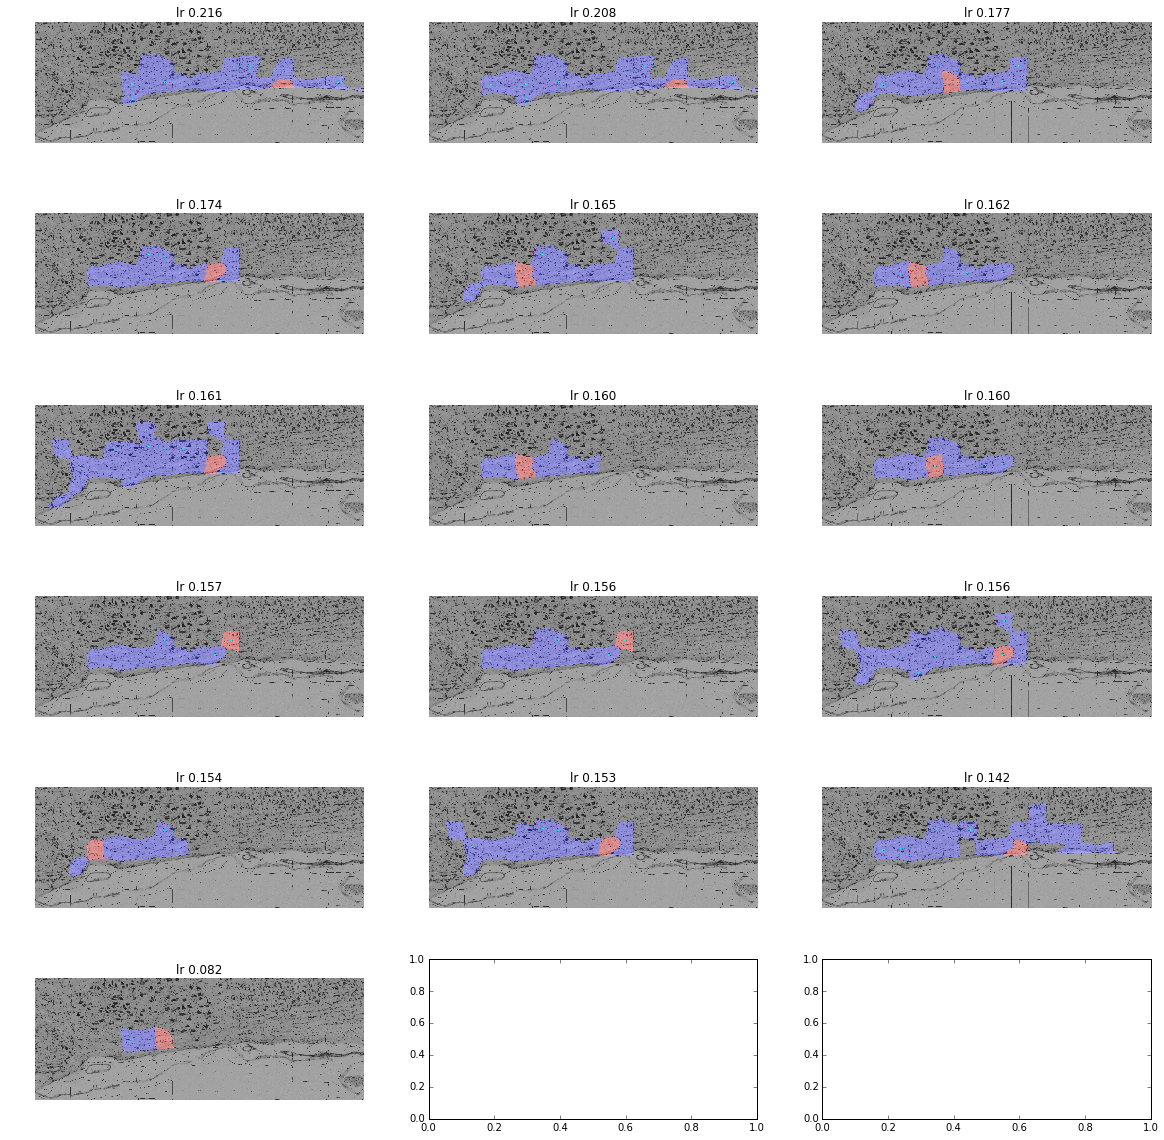

In [120]:
gi = 25
dm.visualize_clusters_in_subplots(all_clusters_grouped_unique[gi], 
                                  titles=['lr %.3f'%all_sigs_grouped[gi][i] 
                                          for i in all_clusters_grouped_unique_indices[gi]])
#                                   titles=['lr %.3f, perc %.2f'%(all_sigs_grouped[gi][i], 
#                                                                 all_sigpercs_grouped[gi][i]) 
#                                           for i in all_clusters_grouped_unique_indices[gi]])

In [111]:
[(rank, group_contrasts[i], group_size[i], group_consensus[i], i) for rank, i in enumerate(group_indices_ranked)]

[(0, 0.38408983528556073, 10, -1.0, 54),
 (1, 0.34608864417128171, 1, -1.0, 235),
 (2, 0.29441963083914108, 35, -10.047619047619047, 20),
 (3, 0.26890063191578717, 17, -2.0, 114),
 (4, 0.26376942790069446, 26, -19.444444444444443, 11),
 (5, 0.23462302015608888, 9, -2.0, 15),
 (6, 0.22531161724494195, 5, -17.550000000000001, 81),
 (7, 0.22017523149989227, 18, -19.85483870967742, 13),
 (8, 0.2168668315507134, 19, -9.0, 30),
 (9, 0.21670526735452761, 8, -17.666666666666668, 17),
 (10, 0.21624453390108062, 19, -17.277777777777779, 25),
 (11, 0.21609835355184639, 3, -2.0, 52),
 (12, 0.21218776300265996, 9, -2.0, 194),
 (13, 0.20848814493335319, 6, -11.75, 26),
 (14, 0.19125936950701986, 9, -9.0999999999999996, 74),
 (15, 0.18709320926329126, 9, -13.529411764705882, 73),
 (16, 0.18690096275483903, 6, -14.6, 5),
 (17, 0.18304929619105201, 18, -15.708333333333334, 12),
 (18, 0.17990562905175683, 18, -18.606060606060606, 14),
 (19, 0.17314661015440044, 15, -9.25, 0),
 (20, 0.16928482977118586, 

In [ ]:
all_scores_grouped[31]

In [ ]:
group_indices_ranked.tolist().index(32)

In [ ]:
# # which group contains the interested sps

# group_indices_ranked.tolist().index(8)

# viz = dm.visualize_edge_sets([good_dedges[63]], show_set_index=True)
viz = dm.visualize_edge_sets([rep_dedges_ranked[34]], show_set_index=True)
# viz = dm.visualize_cluster(rep_clusters_ranked[34])
display(viz)

In [ ]:
print good_clusters[34]

In [ ]:
dm.neighbors[1016]

In [ ]:
dm.find_boundary_dedges_ordered(good_clusters[34], verbose=True)

In [ ]:
dm.dedge_neighbors[(969, 1016)]

In [ ]:
viz = dm.visualize_edge_sets(merged_dedges_ranked[:30], show_set_index=True, bg='segmentationWithoutText')
display(viz)

In [121]:
# for i in range(0, len(good_dedges), 10):
for i in range(0, 100, 10):
    viz = dm.visualize_edge_sets(good_dedges[i:i+10], show_set_index=True)
    try:
        dm.save_pipeline_result(viz, 'landmarks%dViz'%(i+10))
    except:
        pass

saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0138/MD593_0138_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_landmarks10Viz.jpg
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0138/MD593_0138_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_landmarks20Viz.jpg
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0138/MD593_0138_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_landmarks30Viz.jpg
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0138/MD593_0138_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_landmarks40Viz.jpg
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0138/MD593_0138_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_landmarks50Viz.jpg
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593/0138/MD593_0138_lossless_gabor-blueNisslWide-segm-tSLIC200-vq-blueNissl_landmarks60Viz.jpg
saved /oasis/projects/nsf/csd395/yuncong/CSHL_data_results/MD593

In [ ]:
def fit_ellipse_to_points(pts):

    pts = np.array(list(pts) if isinstance(pts, set) else pts)

    c0 = pts.mean(axis=0)

    coords0 = pts - c0

    U,S,V = np.linalg.svd(np.dot(coords0.T, coords0)/coords0.shape[0])
    v1 = U[:,0]
    v2 = U[:,1]
    s1 = np.sqrt(S[0])
    s2 = np.sqrt(S[1])

    return v1, v2, s1, s2, c0

In [ ]:
boundary_models = []

for i, (cl, dedges) in enumerate(zip(good_clusters, good_dedges)[:100]):

    dedge_list = list(dedges)

    interior_texture = dm.texton_hists[list(cl)].mean(axis=0)
    exterior_textures = []
    
    cluster_coords = np.vstack([dm.sp_coords[s] for s in cl])
    ell = fit_ellipse_to_points(cluster_coords)
    
    edge_points = []
    
    for e in dedge_list:
        pts_e = dm.edge_coords[frozenset(e)]
        sample_indices = np.arange(20, len(pts_e)-20, 200)

        if len(sample_indices) > 0:
            sample_pts_e = pts_e[sample_indices]
            edge_points.append(sample_pts_e)
            surr = e[0]
            ext_tex = dm.texton_hists[surr] if surr != -1 else np.nan * np.ones((dm.n_texton,))
            exterior_textures.append([ext_tex for _ in sample_indices])
    
    edge_points = np.vstack(edge_points)
    exterior_textures = np.vstack(exterior_textures)

    center = np.mean([dm.edge_midpoints[frozenset(e)] for e in dedge_list], axis=0)

    boundary_models.append((dedge_list, interior_texture, exterior_textures, edge_points, center) +\
                           ell)


In [ ]:
dm.save_pipeline_result(boundary_models, 'boundaryModels')